# **Red Beads in FITC-Agarose**

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage

In [2]:
# 1. MOUNT GOOGLE DRIVE
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. SET YOUR PATH (Update 'Your_Folder_Name')
# Example: '/content/drive/MyDrive/PhD_Data/Experiment_1'
INPUT_DIR = '/content/drive/My Drive/857/Capture_fluorescent_beads/HHB_control_lyase_x10'
DEXTRAN_TYPE = "control_lyase"
STATE = "Capture"

In [ ]:
# 3. CHANNEL MAPPING:
# For Beads: Detect = 'd1' (FITC-Agarose), Measure = 'd2' (Red Beads)
# For Release: Detect = 'd4' (Phase Contrast), Measure = 'd1' (FITC-Dextran)
DETECTION_SUFFIX = "d1"
MEASUREMENT_SUFFIX = "d2"

In [ ]:
# 4. FILTERS (Adjust based on your x10 images)
MIN_AREA = 5000
CIRCULARITY_LIMIT = 0.7
PEAK_MIN_DIST = 20
SHRINK_FACTOR = 0.9  # Measure 90% of the radius to avoid edge effects

In [ ]:
def run_analysis():
    if not os.path.exists(INPUT_DIR):
        print(f"ERROR: Path not found: {INPUT_DIR}")
        return

    all_files = os.listdir(INPUT_DIR)
    detect_files = sorted([f for f in all_files if f.lower().endswith(f'{DETECTION_SUFFIX}.tif')])

    print(f"Total files: {len(all_files)} | {DETECTION_SUFFIX} sets found: {len(detect_files)}")

    results = []

    for filename in detect_files:
        ext = ".TIF" if filename.endswith(".TIF") else ".tif"
        detect_path = os.path.join(INPUT_DIR, filename)
        measure_path = os.path.join(INPUT_DIR, filename.replace(f"{DETECTION_SUFFIX}{ext}", f"{MEASUREMENT_SUFFIX}{ext}"))

        if not os.path.exists(measure_path):
            continue

        # Load Images
        detect_img = cv2.imread(detect_path, cv2.IMREAD_UNCHANGED)
        measure_img = cv2.imread(measure_path, cv2.IMREAD_UNCHANGED)

        if detect_img is None or measure_img is None: continue

        # Standardize bit depth for processing
        detect_img_float = detect_img.astype(np.float32)
        measure_img_float = measure_img.astype(np.float32)

        # Normalize for mask creation
        detect_8 = cv2.normalize(detect_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        blur = cv2.GaussianBlur(detect_8, (5, 5), 0)

        # 1. THRESHOLDING (Manual threshold 20 to pick up dimmer cores)
        _, thresh = cv2.threshold(blur, 20, 255, cv2.THRESH_BINARY)

        # 2. WATERSHED
        distance = ndimage.distance_transform_edt(thresh)
        local_maxi = peak_local_max(distance, min_distance=PEAK_MIN_DIST, labels=thresh)

        markers = np.zeros(distance.shape, dtype=int)
        for idx, peak in enumerate(local_maxi):
            markers[peak[0], peak[1]] = idx + 1

        labels = watershed(-distance, markers, mask=thresh)

        viz = cv2.cvtColor(detect_8, cv2.COLOR_GRAY2BGR)
        count = 0

        # 3. ANALYZE
        for label in np.unique(labels):
            if label == 0: continue

            mask_single = np.zeros(thresh.shape, dtype="uint8")
            mask_single[labels == label] = 255

            cnts, _ = cv2.findContours(mask_single, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not cnts: continue

            c = cnts[0]
            area = cv2.contourArea(c)
            if area < MIN_AREA: continue

            perimeter = cv2.arcLength(c, True)
            if perimeter == 0: continue
            circularity = 4 * np.pi * (area / (perimeter * perimeter))
            if circularity < CIRCULARITY_LIMIT: continue

            (x, y), radius = cv2.minEnclosingCircle(c)
            center = (int(x), int(y))
            effective_radius = int(radius * SHRINK_FACTOR)

            # 4. RATIOMETRIC MEASUREMENT
            core_mask = np.zeros(thresh.shape, dtype=np.uint8)
            cv2.circle(core_mask, center, effective_radius, 255, -1)

            # Mean intensities (using the float images for precision)
            # detect_img_float is your FITC (Agarose)
            # measure_img_float is your RFP (Beads)
            mean_detect = cv2.mean(detect_img_float, mask=core_mask)[0]
            mean_measure = cv2.mean(measure_img_float, mask=core_mask)[0]

            # Ratio calculation
            ratio = mean_measure / (mean_detect + 0.1)

            results.append({
                'FileName': filename,
                'Detect_Intensity': mean_detect,
                'Measure_Intensity': mean_measure,
                'Intensity_Ratio': ratio,
                'Radius': effective_radius,
                'State': STATE
            })

            cv2.circle(viz, center, effective_radius, (0, 255, 0), 2)
            count += 1

        print(f"Processed {filename}: Found {count} objects")
        cv2_imshow(viz)

        save_name = filename.replace(f"{DETECTION_SUFFIX}{ext}", f"_Watershed_Labeled{ext}")
        cv2.imwrite(os.path.join(INPUT_DIR, save_name), viz)

    if results:
        df = pd.DataFrame(results)
        csv_path = os.path.join(INPUT_DIR, f"Results_Ratiometric_{STATE}.csv")
        df.to_csv(csv_path, index=False)
        print(f"✅ SUCCESS! Ratiometric CSV saved: {csv_path}")

run_analysis()

Output hidden; open in https://colab.research.google.com to view.

# **PLOT**

/tmp/ipython-input-3426192858.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([get_label(g) for g in df['Group'].unique()], fontsize=20)


✅ Exported: 1_Matrix_Signal.png and 1_Matrix_Signal.pdf


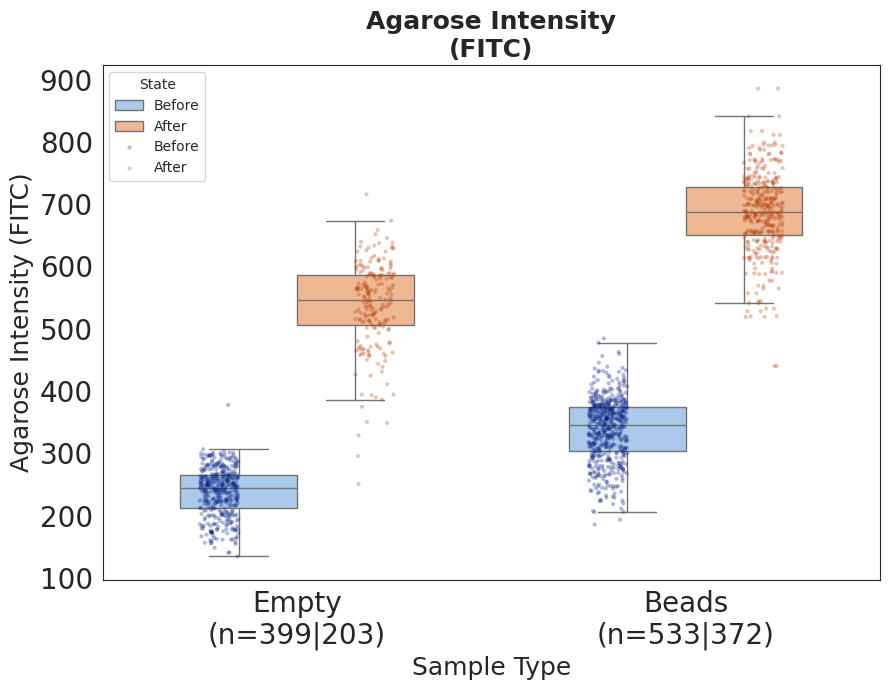

/tmp/ipython-input-3426192858.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([get_label(g) for g in df['Group'].unique()], fontsize=20)


✅ Exported: 2_Cargo_Signal.png and 2_Cargo_Signal.pdf


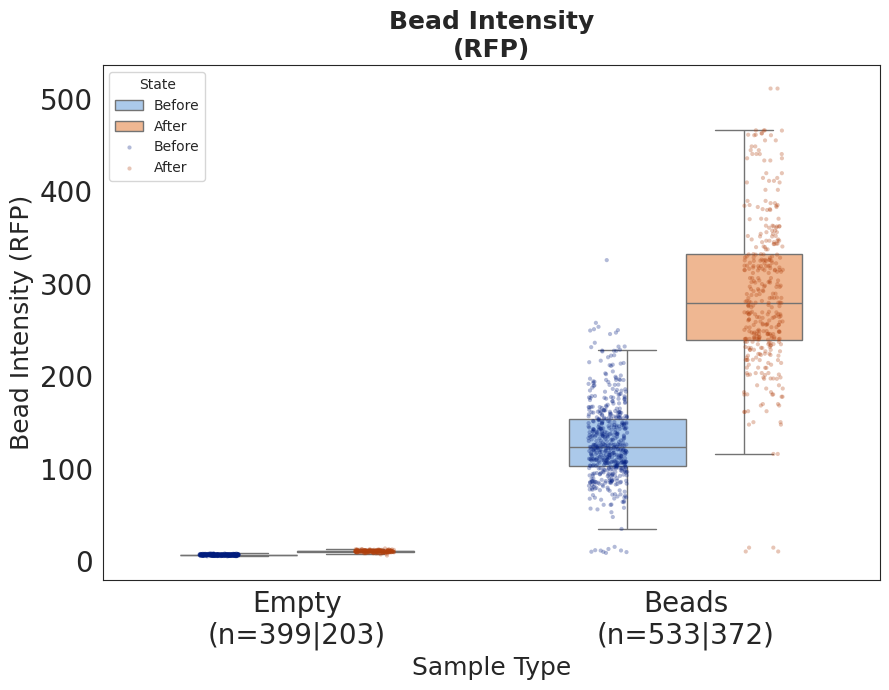

/tmp/ipython-input-3426192858.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([get_label(g) for g in df['Group'].unique()], fontsize=20)


✅ Exported: 3_Normalized_Sequestration.png and 3_Normalized_Sequestration.pdf


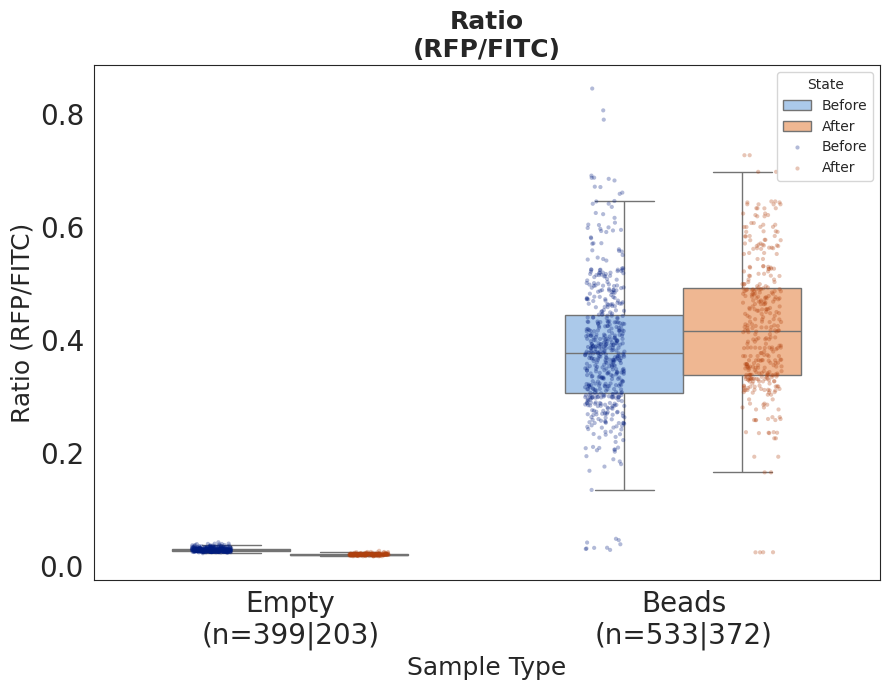

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. DEFINE YOUR FILES
# ==========================================
# You can now put a LIST of files if you have more than one for a category
file_config = {
    ('Empty', 'Before'): ['/content/drive/My Drive/857/Capture_fluorescent_beads/HHB_control_x10/Results_Ratiometric_Capture.csv'],
    ('Empty', 'After'): ['/content/drive/My Drive/857/Capture_fluorescent_beads/HHB_control_lyase_x10/Results_Ratiometric_Capture.csv'],
    ('Beads', 'Before'): ['/content/drive/My Drive/857/Capture_fluorescent_beads/HHB_beads_x10/Results_Ratiometric_Capture.csv'],
    ('Beads', 'After'): ['/content/drive/My Drive/857/Capture_fluorescent_beads/HHB_beads_lyase_x10_0/Results_Ratiometric_Capture.csv',
                '/content/drive/My Drive/857/Capture_fluorescent_beads/HHB_beads_lyase_x10_0/Results_Ratiometric_Capture.csv']
}

all_data = []

for (group, state), files in file_config.items():
    for f in files:
        if os.path.exists(f):
            temp_df = pd.read_csv(f)
            temp_df['Group'] = group
            temp_df['State'] = state
            all_data.append(temp_df)
        else:
            print(f"⚠️ Warning: File not found: {f}")

if not all_data:
    print("❌ No data found. Please check filenames.")
else:
    df = pd.concat(all_data, ignore_index=True)

    # Calculate n-counts for labels
    counts = df.groupby(['Group', 'State']).size().to_dict()
    def get_label(g):
        n_b = counts.get((g, 'Before'), 0)
        n_a = counts.get((g, 'After'), 0)
        return f"{g}\n(n={n_b}|{n_a})"

    # ==========================================
# 2. INDIVIDUAL EXPORT LOOP
# ==========================================
metrics = [
    ('Detect_Intensity', 'Agarose Intensity (FITC)', '1_Matrix_Signal'),
    ('Measure_Intensity', 'Bead Intensity (RFP)', '2_Cargo_Signal'),
    ('Intensity_Ratio', 'Ratio (RFP/FITC)', '3_Normalized_Sequestration')
]

sns.set_style("white")

for col, ylabel, filename in metrics:
    # Set a square or slightly horizontal aspect ratio for single slides
    plt.figure(figsize=(9, 7))

    # Create the plot
    ax = sns.boxplot(data=df, x='Group', y=col, hue='State',
                    palette='pastel', showfliers=False, width=0.6)
    sns.stripplot(data=df, x='Group', y=col, hue='State',
                  dodge=True, alpha=0.3, size=3, palette='dark')

    # Customization
    plt.title(ylabel.replace(' (', '\n('), fontweight='bold', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.yticks(fontsize=20)
    plt.xlabel('Sample Type', fontsize=18)
    ax.set_xticklabels([get_label(g) for g in df['Group'].unique()], fontsize=20)

    # Legend management
    # plt.legend(title='Process Stage', title_fontsize='18', fontsize='16',loc='upper left')

    # Save as High-Res PNG (300 DPI) and PDF (Vector)
    plt.tight_layout()
    plt.savefig(f'{filename}.png', dpi=300)
    plt.savefig(f'{filename}.pdf') # PDF is best for Dissertation printing
    print(f"✅ Exported: {filename}.png and {filename}.pdf")
    plt.show()

✅ Saved: 1_Matrix_Signal.png (p-values included)


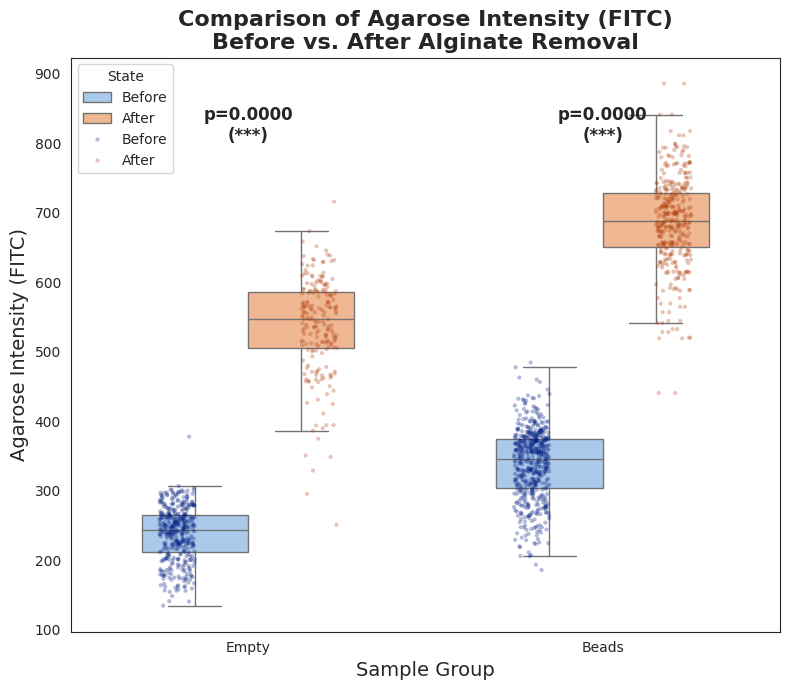

✅ Saved: 2_Cargo_Signal.png (p-values included)


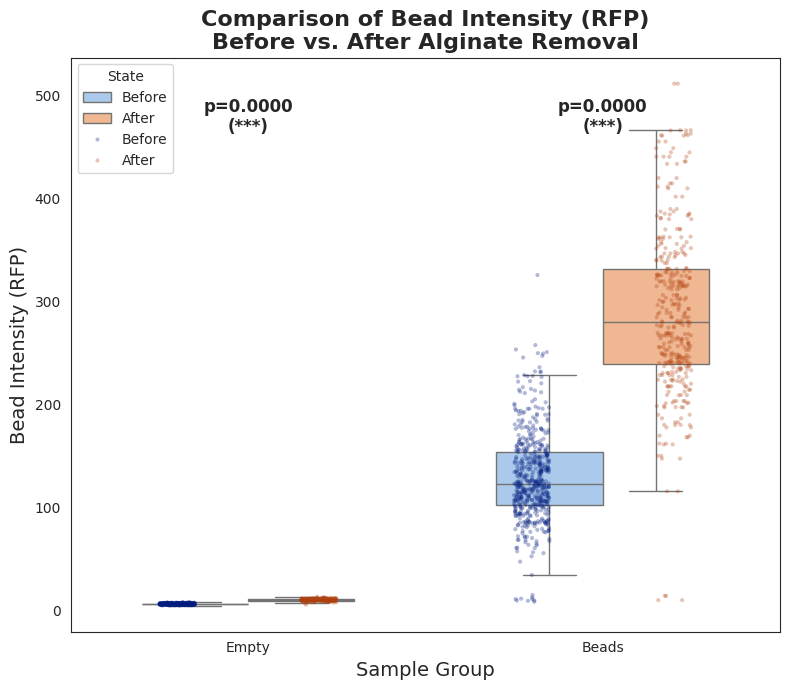

✅ Saved: 3_Normalized_Sequestration.png (p-values included)


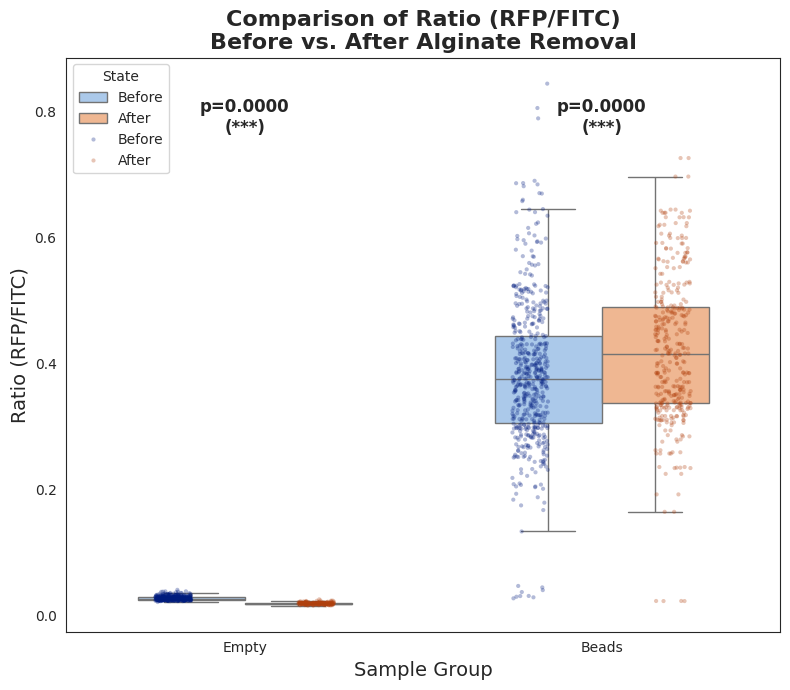

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind

# ==========================================
# 1. DEFINE YOUR FILES
# ==========================================
# You can now put a LIST of files if you have more than one for a category
file_config = {
    ('Empty', 'Before'): ['/content/drive/My Drive/857/Capture_fluorescent_beads/HHB_control_x10/Results_Ratiometric_Capture.csv'],
    ('Empty', 'After'): ['/content/drive/My Drive/857/Capture_fluorescent_beads/HHB_control_lyase_x10/Results_Ratiometric_Capture.csv'],
    ('Beads', 'Before'): ['/content/drive/My Drive/857/Capture_fluorescent_beads/HHB_beads_x10/Results_Ratiometric_Capture.csv'],
    ('Beads', 'After'): ['/content/drive/My Drive/857/Capture_fluorescent_beads/HHB_beads_lyase_x10_0/Results_Ratiometric_Capture.csv',
                '/content/drive/My Drive/857/Capture_fluorescent_beads/HHB_beads_lyase_x10_0/Results_Ratiometric_Capture.csv']
}

all_data = []
for (group, state), files in file_config.items():
    for f in files:
        if os.path.exists(f):
            temp_df = pd.read_csv(f)
            temp_df['Group'] = group
            temp_df['State'] = state
            all_data.append(temp_df)

if not all_data:
    print("Please ensure CSV files are in the directory.")
else:
    df = pd.concat(all_data, ignore_index=True)

    # Metrics to plot
    metrics = [
        ('Detect_Intensity', 'Agarose Intensity (FITC)', '1_Matrix_Signal'),
        ('Measure_Intensity', 'Bead Intensity (RFP)', '2_Cargo_Signal'),
        ('Intensity_Ratio', 'Ratio (RFP/FITC)', '3_Normalized_Sequestration')
    ]

    sns.set_style("white")

    for col, ylabel, filename in metrics:
        plt.figure(figsize=(8, 7))

        # 1. Draw the plot
        ax = sns.boxplot(data=df, x='Group', y=col, hue='State',
                         palette='pastel', showfliers=False, width=0.6)
        sns.stripplot(data=df, x='Group', y=col, hue='State',
                      dodge=True, alpha=0.3, size=3, palette='dark')

        # 2. Statistical Analysis (T-Test)
        for i, group_name in enumerate(df['Group'].unique()):
            # Filter data for the specific group
            before = df[(df['Group'] == group_name) & (df['State'] == 'Before')][col]
            after = df[(df['Group'] == group_name) & (df['State'] == 'After')][col]

            if len(before) > 0 and len(after) > 0:
                stat, p = ttest_ind(before, after)

                # Significance annotation logic
                y_max = df[col].max() * 0.9  # Position for the p-value label
                x_pos = i

                if p < 0.001: sig = "***"
                elif p < 0.01: sig = "**"
                elif p < 0.05: sig = "*"
                else: sig = "ns"

                # Add text to plot
                plt.text(x_pos, y_max, f"p={p:.4f}\n({sig})",
                         ha='center', va='bottom', fontsize=12, fontweight='bold')

        # 3. Customization
        plt.title(f"Comparison of {ylabel}\nBefore vs. After Alginate Removal", fontweight='bold', fontsize=16)
        plt.ylabel(ylabel, fontsize=14)
        plt.xlabel('Sample Group', fontsize=14)

        plt.tight_layout()
        plt.savefig(f'{filename}.png', dpi=300)
        print(f"✅ Saved: {filename}.png (p-values included)")
        plt.show()